In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import io

## plant vs model

      Ts (degC)      I (a.u.)  P (W)  q (slm)
0         33.65  9.373740e+05    1.5      3.5
1         33.62  6.896790e+05    1.5      3.5
2         33.43  6.303913e+05    1.5      3.5
3         32.90  5.622200e+05    1.5      3.5
4         32.93  6.410619e+05    1.5      3.5
...         ...           ...    ...      ...
3835      51.86  1.471212e+06    4.5      3.0
3836      51.83  1.495386e+06    4.5      3.0
3837      51.97  1.491573e+06    4.5      3.0
3838      51.79  1.456939e+06    4.5      3.0
3839      51.83  1.453891e+06    4.5      3.0

[3840 rows x 4 columns]
[[3.36500000e+01 9.37373960e+05 1.50000000e+00 3.50000000e+00]
 [3.36200000e+01 6.89679007e+05 1.50000000e+00 3.50000000e+00]
 [3.34300000e+01 6.30391266e+05 1.50000000e+00 3.50000000e+00]
 ...
 [5.19700000e+01 1.49157266e+06 4.50000000e+00 3.00000000e+00]
 [5.17900000e+01 1.45693864e+06 4.50000000e+00 3.00000000e+00]
 [5.18300000e+01 1.45389139e+06 4.50000000e+00 3.00000000e+00]]


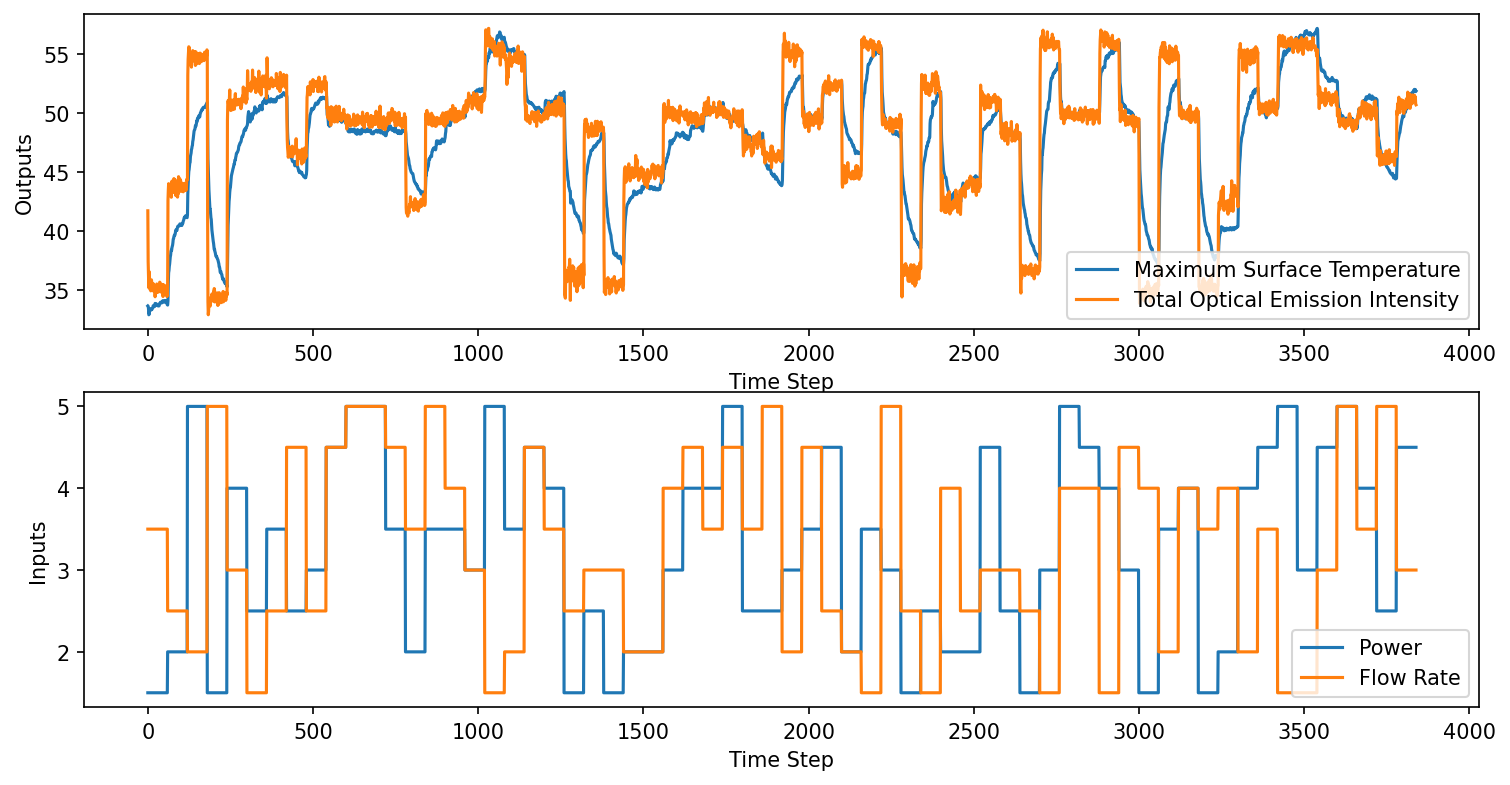

In [14]:
## load data
# 2021 data
data_2021 = pd.read_csv(
    "2021_06_08_15h57m55s_dataCollectionOL.csv"
)
print(data_2021)
data_2021 = data_2021.to_numpy()
print(data_2021)
data_2021[:, 1] = data_2021[:, 1] / 0.75e5
# data_2021 = data_2021[120:, :]

# scale I to Ts range
Imin = np.min(data_2021[:, 1])
Imax = np.max(data_2021[:, 1])
Tmin = np.min(data_2021[:, 0])
Tmax = np.max(data_2021[:, 0])
Idata = (data_2021[:, 1] - Imin) / (Imax - Imin)  # normalize to [0, 1]
Idata = Idata * (Tmax - Tmin) + Tmin  # scale to Ts range

# plot to visualize data
fig = plt.figure(figsize=(12, 6), dpi=150)
ax = fig.add_subplot(211)
ax.plot(data_2021[:, 0], label="Maximum Surface Temperature")
ax.plot(Idata, label="Total Optical Emission Intensity")
ax.set_xlabel("Time Step")
ax.set_ylabel("Outputs")
# ax.set_title('Outputs')
ax.legend(loc="lower right")
ax = fig.add_subplot(212)
ax.plot(data_2021[:, 2], label="Power")
ax.plot(data_2021[:, 3], label="Flow Rate")
ax.set_xlabel("Time Step")
ax.set_ylabel("Inputs")
# ax.set_title('Inputs')
ax.legend()
plt.show()

Linear Model to be used for the CONTROL:
A:  [[0.90268351 0.0175441 ]
 [0.13155243 0.24256854]]
B:  [[ 0.58145481 -0.22042118]
 [ 2.67365891 -1.13104991]]
C:  [[1 0]
 [0 1]]
Linear Model to be used for the PLANT:
A:  [[0.88754486 0.05459241]
 [0.09345649 0.28265964]]
B:  [[ 0.50282961 -0.17397488]
 [ 2.7636534  -1.03664163]]
C:  [[1 0]
 [0 1]]


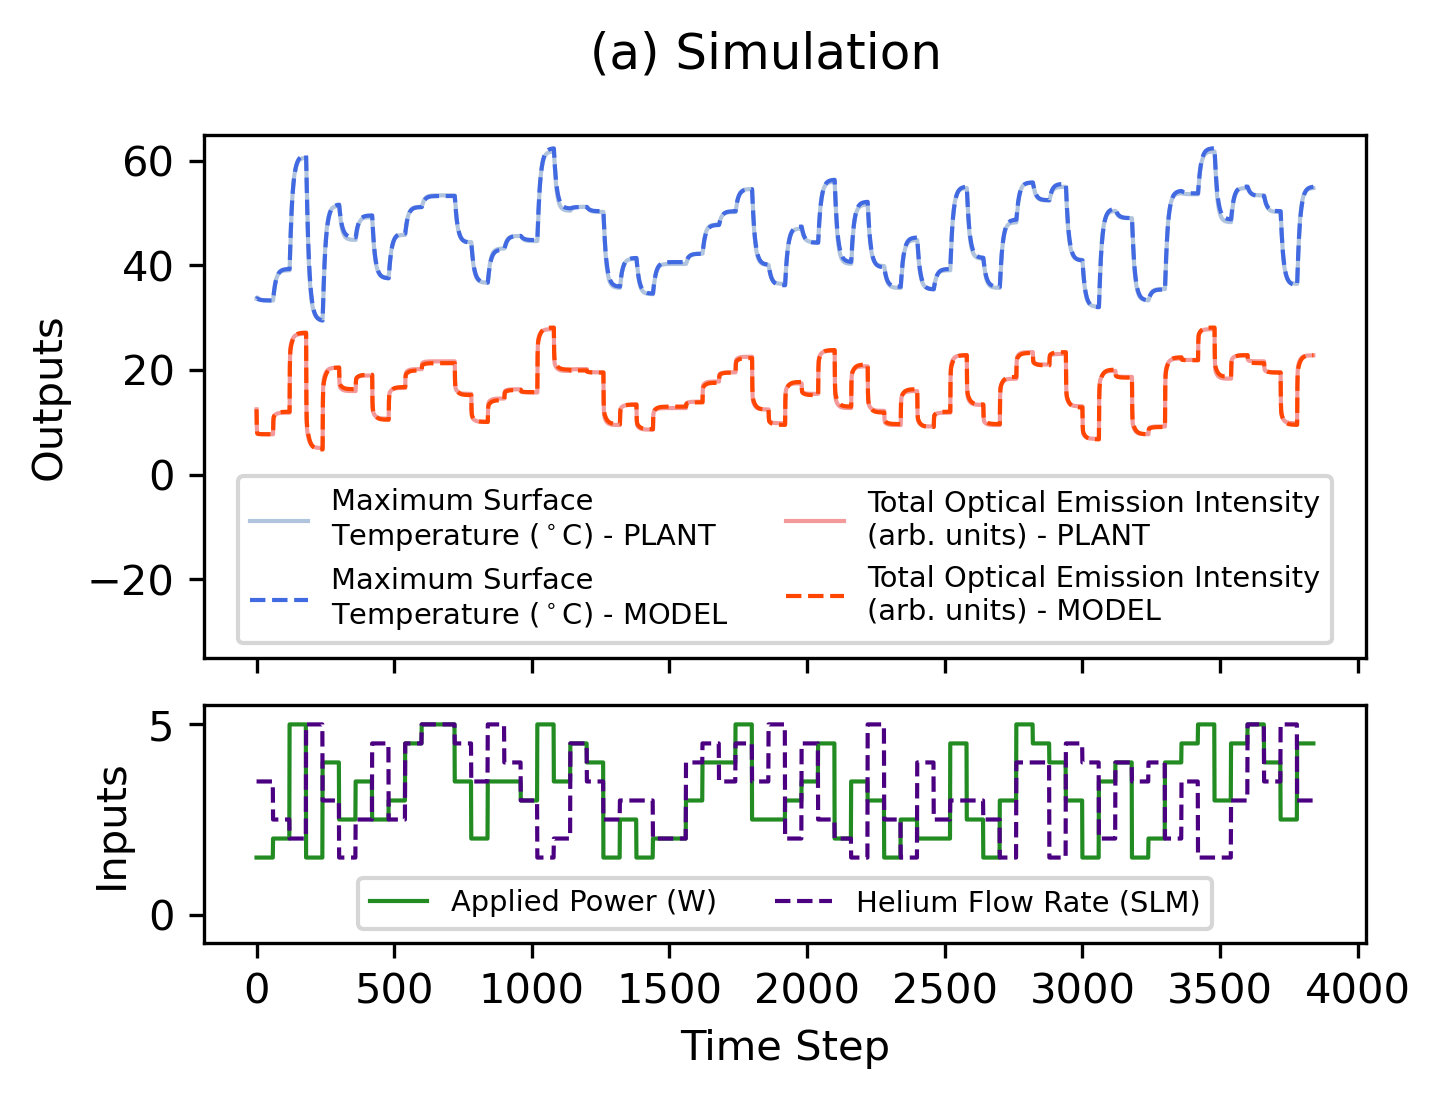

In [27]:
plt.rc('lines', linewidth=1)
## load system matrices from Data model ID
# model identified using n4sid all data
model = io.loadmat("APPJmodel_2021_06_08_15h57m55s_n4sid_alldata.mat")
A = model["A"]
B = model["B"]
C = model["C"]
xss = np.ravel(model["yss"])  # [Ts; I] # 2021 data
uss = np.ravel(model["uss"])  # [P; q] # 2021 data
print("Linear Model to be used for the CONTROL:")
print("A: ", A)
print("B: ", B)
print("C: ", C)
model = io.loadmat("APPJmodel_2021_06_08_15h57m55s_n4sid_50split.mat")
Ap = model["A"]
Bp = model["B"]
Cp = model["C"]
xssp = np.ravel(model["yss"])  # [Ts; I] # 2021 data
ussp = np.ravel(model["uss"])  # [P; q] # 2021 data
print("Linear Model to be used for the PLANT:")
print("A: ", Ap)
print("B: ", Bp)
print("C: ", Cp)

Nsim = len(data_2021[:, 0]) - 1
Ypred = np.zeros_like(data_2021[:, :2])
Ypredp = np.zeros_like(data_2021[:, :2])
Ypred[0, :] = np.ravel(data_2021[0, :2] - xss)
Ypredp[0, :] = np.ravel(data_2021[0, :2] - xssp)
for k in range(Nsim):
    x = Ypred[k, :].reshape(-1, 1)
    u = (data_2021[k, 2:] - uss).reshape(-1, 1)

    Ypred[k + 1, :] = np.ravel(A @ x + B @ u)

    x = Ypredp[k, :].reshape(-1, 1)
    u = (data_2021[k, 2:] - ussp).reshape(-1, 1)

    Ypredp[k + 1, :] = np.ravel(Ap @ x + Bp @ u)

# plot to visualize data
fig, axd = plt.subplot_mosaic(
    [["top"], ["top"], ["bottom"]], sharex=True, figsize=(5, 3.5), dpi=300
)
ax = axd["top"]
ax.plot(
    Ypredp[:, 0] + xssp[0],
    ls="-",
    color="lightsteelblue",
    label="Maximum Surface\nTemperature ($^\circ$C) - PLANT",
)
ax.plot(
    Ypred[:, 0] + xss[0],
    ls="--",
    color="royalblue",
    label="Maximum Surface\nTemperature ($^\circ$C) - MODEL",
)
ax.plot(
    Ypredp[:, 1] + xssp[1],
    ls="-",
    color="lightcoral",
    alpha=0.8,
    label="Total Optical Emission Intensity\n(arb. units) - PLANT",
)
ax.plot(
    Ypred[:, 1] + xss[1],
    ls="--",
    color="orangered",
    label="Total Optical Emission Intensity\n(arb. units) - MODEL",
)
fig.suptitle('(a) Simulation')
# ax.set_xlabel("Time Step")
ax.set_ylim([-35, 65])
ax.set_ylabel("Outputs")
# ax.set_title('Outputs')
ax.legend(loc="lower center", ncol=2, fontsize='x-small')
# ax = fig.add_subplot(212)
ax = axd["bottom"]
ax.plot(data_2021[:, 2], color="forestgreen", label="Applied Power (W)")
ax.plot(data_2021[:, 3], color="indigo", ls="--", label="Helium Flow Rate (SLM)")
ax.set_xlabel("Time Step")
ax.set_ylabel("Inputs")
# ax.set_title('Inputs')
ax.set_ylim([-0.75, 5.5])
ax.legend(loc="lower center", ncol=2, fontsize='x-small')
plt.show()

sim = {}
sim["Ypred"] = Ypred
sim["Ypredp"] = Ypredp
sim["power"] = data_2021[:, 2]
sim["flow"] = data_2021[:, 3]

## experiment model vs data

      Ts (degC)      I (a.u.)  P (W)  q (slm)
0         33.25  1.677653e+06    0.0      0.0
1         34.16  1.553060e+06    0.0      0.0
2         33.58  1.578246e+06    0.0      0.0
3         33.14  1.578486e+06    0.0      0.0
4         32.95  1.587401e+06    0.0      0.0
...         ...           ...    ...      ...
1735      40.53  1.866972e+06    1.5      3.5
1736      40.47  1.873575e+06    1.5      3.5
1737      40.31  1.824124e+06    1.5      3.5
1738      40.35  1.841312e+06    1.5      3.5
1739      40.28  1.865436e+06    1.5      3.5

[1740 rows x 4 columns]
[[3.32500000e+01 1.67765301e+06 0.00000000e+00 0.00000000e+00]
 [3.41600000e+01 1.55305989e+06 0.00000000e+00 0.00000000e+00]
 [3.35800000e+01 1.57824602e+06 0.00000000e+00 0.00000000e+00]
 ...
 [4.03100000e+01 1.82412373e+06 1.50000000e+00 3.50000000e+00]
 [4.03500000e+01 1.84131164e+06 1.50000000e+00 3.50000000e+00]
 [4.02800000e+01 1.86543641e+06 1.50000000e+00 3.50000000e+00]]


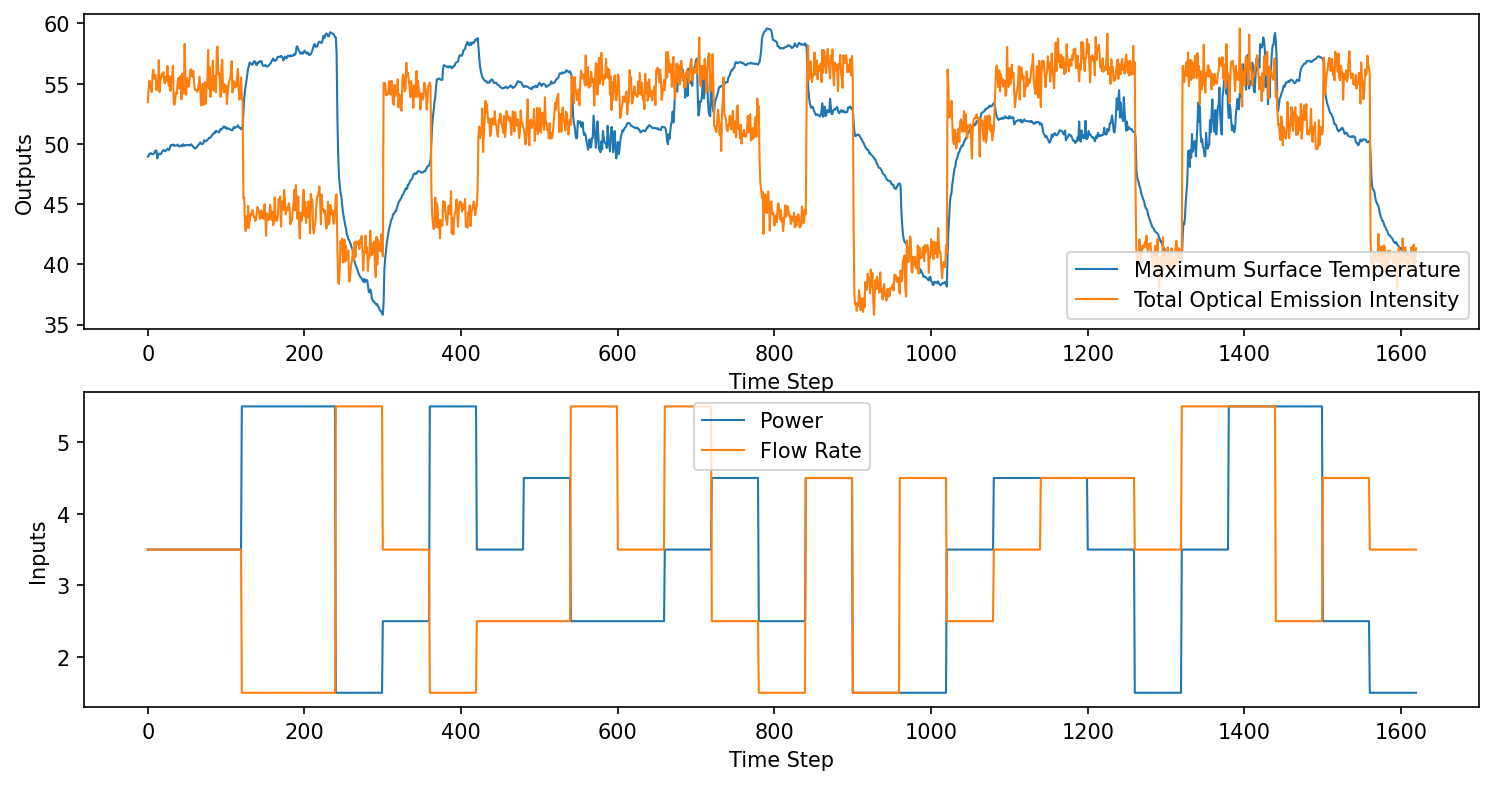

In [28]:
## load data
# 2021 data
data_2021 = pd.read_csv(
    "../matlab/ExperimentalData/2022_07_22_11h40m51s/OL_data_0_inputOutputData.csv"
)
print(data_2021)
data_2021 = data_2021.to_numpy()
print(data_2021)
data_2021[:,1] = data_2021[:,1]/0.75e5
data_2021 = data_2021[120:,:]

# scale I to Ts range
Imin = np.min(data_2021[:, 1])
Imax = np.max(data_2021[:, 1])
Tmin = np.min(data_2021[:, 0])
Tmax = np.max(data_2021[:, 0])
Idata = (data_2021[:, 1] - Imin) / (Imax - Imin)  # normalize to [0, 1]
Idata = Idata * (Tmax - Tmin) + Tmin  # scale to Ts range

# plot to visualize data
fig = plt.figure(figsize=(12,6),dpi=150)
ax = fig.add_subplot(211)
ax.plot(data_2021[:, 0], label="Maximum Surface Temperature")
ax.plot(Idata, label="Total Optical Emission Intensity")
ax.set_xlabel("Time Step")
ax.set_ylabel("Outputs")
# ax.set_title('Outputs')
ax.legend(loc="lower right")
ax = fig.add_subplot(212)
ax.plot(data_2021[:, 2], label="Power")
ax.plot(data_2021[:, 3], label="Flow Rate")
ax.set_xlabel("Time Step")
ax.set_ylabel("Inputs")
# ax.set_title('Inputs')
ax.legend()
plt.show()

Linear Model to be used for the CONTROL:
A:  [[ 0.84507443  0.01628007]
 [-0.06041168  0.35844712]]
B:  [[ 0.44969787 -0.16394255]
 [ 0.71282242  0.56684805]]
C:  [[1 0]
 [0 1]]


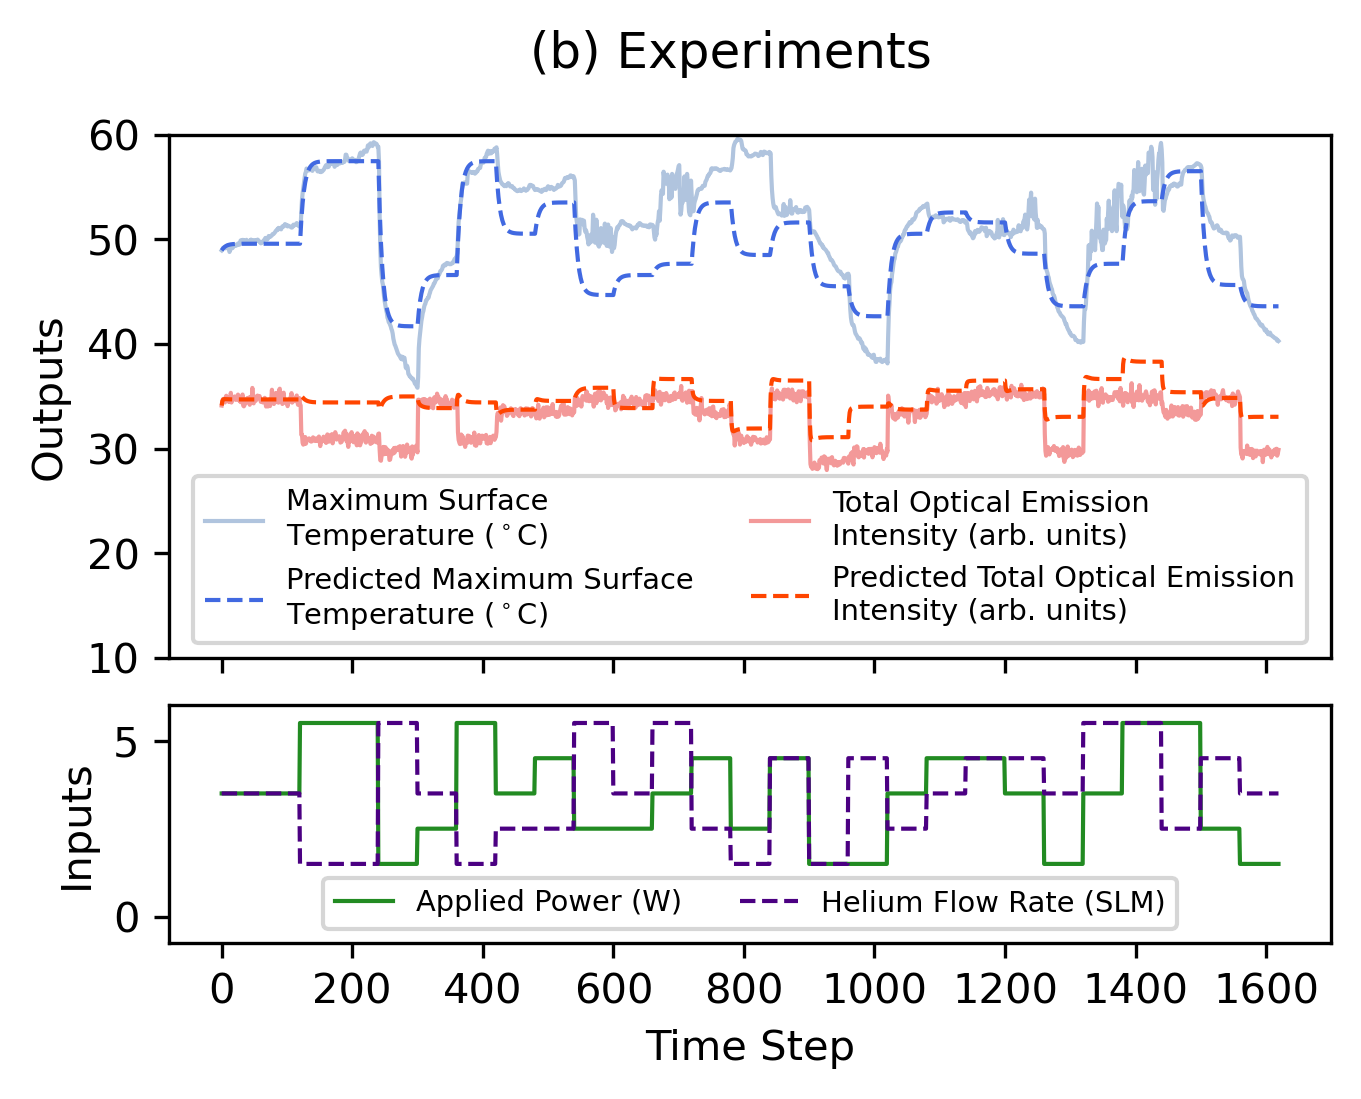

In [32]:
## load system matrices from Data model ID
# model identified using n4sid all data
model = io.loadmat("APPJmodel_2022_07_22_11h40m51s.mat") 
Ap = model["A"]
Bp = model["B"]
Cp = model["C"]
xssp = np.ravel(model["yss"])  # [Ts; I] # 2021 data
ussp = np.ravel(model["uss"])  # [P; q] # 2021 data
print("Linear Model to be used for the CONTROL:")
print("A: ", Ap)
print("B: ", Bp)
print("C: ", Cp)

Nsim = len(data_2021[:, 0]) - 1
Ypred = np.zeros_like(data_2021[:, :2])
Ypred[0, :] = np.ravel(data_2021[0, :2] - xssp)
for k in range(Nsim):
    x = Ypred[k, :].reshape(-1, 1)
    u = (data_2021[k, 2:]-ussp).reshape(-1, 1)

    Ypred[k + 1, :] = np.ravel(Ap @ x + Bp @ u)


# plot to visualize data
fig, axd = plt.subplot_mosaic([["top"],
                               ["top"],
                               ["bottom"]], sharex=True, figsize=(5,3.5), dpi=300)
# fig = plt.figure(figsize=(12,8),dpi=150)
# ax = fig.add_subplot(211)
ax = axd["top"]
ax.plot(data_2021[:, 0], ls='-', color='lightsteelblue', label="Maximum Surface\nTemperature ($^\circ$C)")
ax.plot(Ypred[:, 0] + xssp[0], ls='--', color='royalblue', label="Predicted Maximum Surface\nTemperature ($^\circ$C)")
ax.plot(data_2021[:, 1]+5, ls='-', color='lightcoral', alpha=0.8, label="Total Optical Emission\nIntensity (arb. units)")
ax.plot(Ypred[:, 1] + xssp[1]+5, ls='--', color='orangered', label="Predicted Total Optical Emission\nIntensity (arb. units)")
fig.suptitle('(b) Experiments')
# ax.set_xlabel("Time Step")
ax.set_ylim([10.0,60])
ax.set_ylabel("Outputs")
# ax.set_title('Outputs')
ax.legend(loc="lower center",ncol=2, fontsize='x-small')
# ax = fig.add_subplot(212)
ax = axd["bottom"]
ax.plot(data_2021[:, 2], color="forestgreen", label="Applied Power (W)")
ax.plot(data_2021[:, 3], color="indigo", ls="--", label="Helium Flow Rate (SLM)")
ax.set_xlabel("Time Step")
ax.set_ylabel("Inputs")
# ax.set_title('Inputs')
ax.set_ylim([-0.75,6.0])
ax.legend(loc="lower center", ncol=2, fontsize='x-small')
plt.show()

exp = {}
exp["Ypred"] = Ypred
exp["Ypredp"] = data_2021[:, :1]
exp["power"] = data_2021[:, 2]
exp["flow"] = data_2021[:, 3]